# Visualizing Spectra with SIMPLE 

## Imports

In [1]:
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from specutils import Spectrum

from sqlalchemy import and_, or_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

In [3]:
# Load in the database
from astrodb_utils import load_astrodb
from simple import REFERENCE_TABLES

SCHEMA_PATH = "../../simple/schema.yaml" 
recreatedb = False #Set to True or False
db = load_astrodb(
     "../../SIMPLE.sqlite", 
     recreatedb=recreatedb,  
     reference_tables=REFERENCE_TABLES, 
     felis_schema=SCHEMA_PATH
     )

## Lets try first plotting a single spectra from a single source

In this use case, we are looking to plot the spectra for the object with the most spectra available in SIMPLE. Using what we just learned, we can use SQL to query the database for this answer.

In [15]:
from specutils import Spectrum
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
plt.rcParams['font.family'] = 'serif'

Lets do an inventory check of '2MASS J04151954-0935066' using db.inventory (https://astrodbkit.readthedocs.io/en/latest/astrodb.html#astrodbkit.astrodb.Database.inventory)

In [16]:
results = db.inventory("2MASS J04151954-0935066")

Now lets parse through that dictionary output to only view the spectra associated with 2MASS 0415

In [17]:
results["Spectra"]

[{'access_url': 'https://s3.amazonaws.com/bdnyc/IRS/0415-0935%20%28LL2%29.txt',
  'original_spectrum': None,
  'local_spectrum': '$BDNYC_spectra/IRS/0415-0935 (LL2).txt',
  'regime': 'mir',
  'telescope': 'Spitzer',
  'instrument': 'IRS',
  'mode': 'Missing',
  'observation_date': datetime.datetime(2005, 9, 6, 0, 0),
  'comments': None,
  'reference': 'PID3259',
  'other_references': None},
 {'access_url': 'https://s3.amazonaws.com/bdnyc/IRS/0415-0935.txt',
  'original_spectrum': None,
  'local_spectrum': '$BDNYC_spectra/IRS/0415-0935.txt',
  'regime': 'mir',
  'telescope': 'Spitzer',
  'instrument': 'IRS',
  'mode': 'Missing',
  'observation_date': datetime.datetime(2005, 9, 7, 0, 0),
  'comments': None,
  'reference': 'PID3431',
  'other_references': None},
 {'access_url': 'https://bdnyc.s3.amazonaws.com/IRS/2MASS+J04151954-0935066.fits',
  'original_spectrum': 'https://bdnyc.s3.amazonaws.com/IRS/0415-0935_IRS_spectrum.dat',
  'local_spectrum': None,
  'regime': 'mir',
  'telescope':

Lets first plot up just one of these spectra, you can directly copy the link from the dictionary and use Spectrum to visualize the data

Text(0.5, 1.0, 'JWST NIRSpec Spectrum of 2MASS J04151954-0935066')

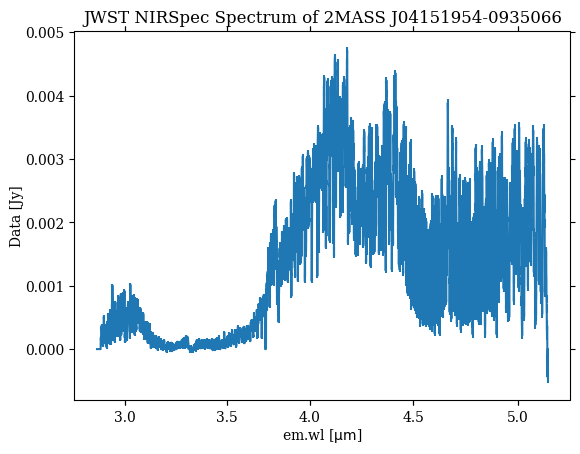

In [18]:
jwst = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/JWST/NIRSpec/jw02124-o059_s00001_nirspec_f290lp-g395h-s200a1-subs200a1_x1d_manual.fits')
jwst.plot()
plt.title('JWST NIRSpec Spectrum of 2MASS J04151954-0935066')

Text(0.5, 1.0, 'FIRE Spectrum of 2MASS J04151954-0935066')

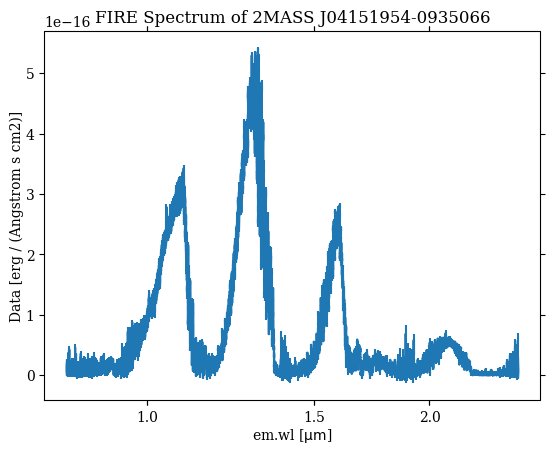

In [19]:
fire = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/FIRE/FIRE_0415-0935.fits')
fire.plot()
plt.title('FIRE Spectrum of 2MASS J04151954-0935066')

Text(0.5, 1.0, 'AKARI Spectrum of 2MASS J04151954-0935066')

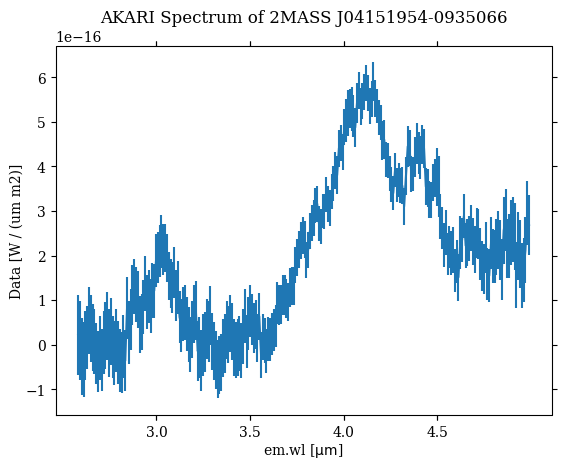

In [20]:
akari = Spectrum.read('https://bdnyc.s3.us-east-1.amazonaws.com/AKARI_2MASS%2BJ04151954-0935066_2007-08-23.fits')
akari.plot()
plt.title('AKARI Spectrum of 2MASS J04151954-0935066')

## Plotting Multiple Spectra of a Single Object

### Converting wavelength and flux units

The Spectrum.read function automatically picks up on the units within the fits file, and you can see from each of these that the flux is at different units so to be able to plot them all together we would need to do some unit conversion to better visualize them. Lets do that next!

In [203]:
# Converting the outlier spectra to the same units (JWST NIRSpec Spectra is in Jy)
jwst_wavelength, flux = jwst.spectral_axis, jwst.flux
target_unit = u.W / (u.um * u.m**2)  # Desired flux unit
 
jwst_flux_converted = flux.to(target_unit, equivalencies=u.spectral_density(jwst_wavelength))

### Plotting

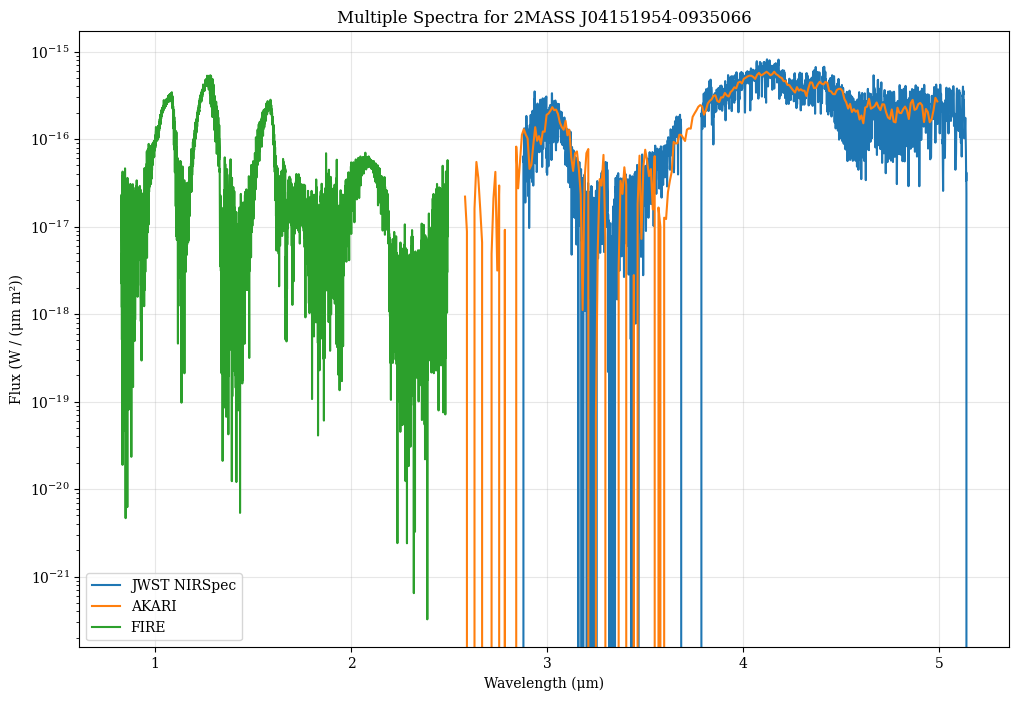

In [204]:
plt.figure(figsize=(12, 8))

plt.plot(jwst_wavelength, jwst_flux_converted, label='JWST NIRSpec')
plt.plot(akari.spectral_axis, akari.flux, label='AKARI')
plt.plot(fire.spectral_axis, fire.flux, label='FIRE')

# Add labels and title
plt.xlabel('Wavelength (μm)')
plt.ylabel('Flux (W / (μm m²))')
plt.title('Multiple Spectra for 2MASS J04151954-0935066')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

# Display the plot
plt.show()

### Adding Formatting (Making it Fancy)

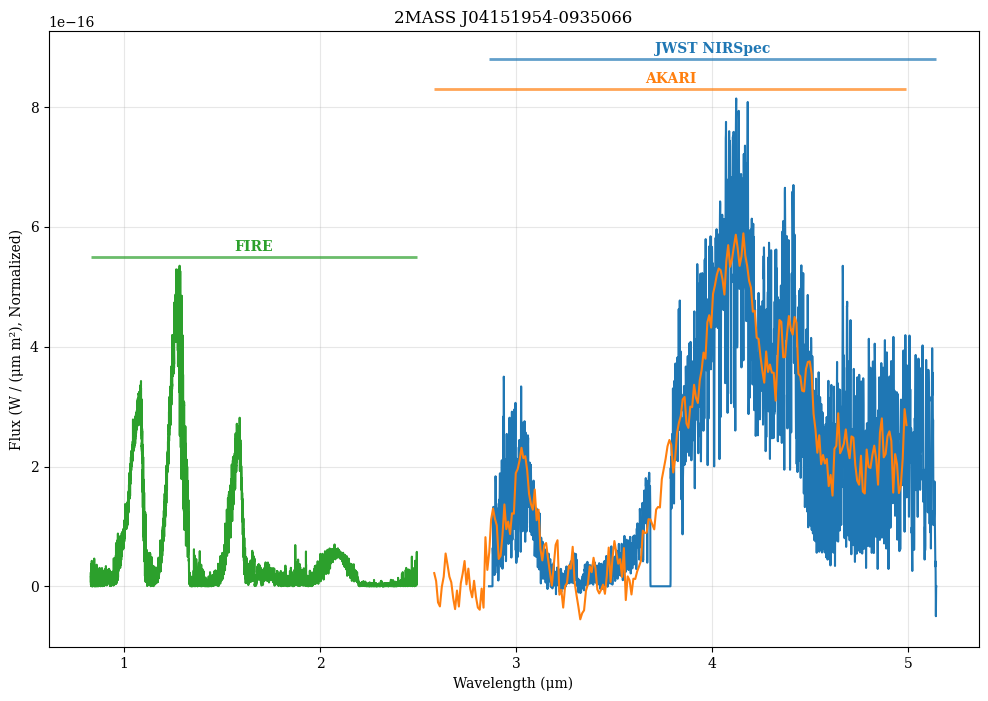

In [205]:
plt.figure(figsize=(12, 8))

plt.plot(jwst_wavelength, jwst_flux_converted, label='JWST NIRSpec')
plt.plot(akari.spectral_axis, akari.flux, label='AKARI')
plt.plot(fire.spectral_axis, fire.flux, label='FIRE')

# Add labels and title
plt.xlabel('Wavelength (μm)')
plt.ylabel('Flux (W / (μm m²), Normalized)')
plt.title('2MASS J04151954-0935066')
plt.grid(True, alpha=0.3)

jwst_range = [jwst_wavelength.value.min(), jwst_wavelength.value.max()]
akari_range = [akari.spectral_axis.value.min(), akari.spectral_axis.value.max()]
fire_range = [fire.spectral_axis.value.min(), fire.spectral_axis.value.max()]

# Annotate the plot with Matplotlib's hlines and text functions

#JWST
plt.hlines(8.8e-16, jwst_range[0], jwst_range[1], 
           colors=plt.gca().lines[0].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((jwst_range[0] + jwst_range[1])/2, 8.9e-16, 'JWST NIRSpec', 
         color=plt.gca().lines[0].get_color(), fontweight='bold', ha='center')

#AKARI
plt.hlines(8.3e-16, akari_range[0], akari_range[1], 
           colors=plt.gca().lines[1].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((akari_range[0] + akari_range[1])/2, 8.4e-16, 'AKARI', 
         color=plt.gca().lines[1].get_color(), fontweight='bold', ha='center')

#FIRE 
plt.hlines(0.55e-15, fire_range[0], fire_range[1], 
           colors=plt.gca().lines[2].get_color(), linestyles='-', linewidth=2, alpha=0.7)
plt.text((fire_range[0] + fire_range[1])/2, 0.56e-15, 'FIRE', 
         color=plt.gca().lines[2].get_color(), fontweight='bold', ha='center')

plt.show()